# Quantum Nearest Neighbors

___________
In this Notebook, I will implement the algorithm introduced in [this paper](https://arxiv.org/pdf/1412.3646.pdf) by [Maria Schuld](https://scholar.google.com/citations?user=_ih_hwUAAAAJ&hl=en), [Ilya Sinayskiy](https://scholar.google.co.za/citations?user=tL1_WfsAAAAJ&hl=en) and [Francesco Petruccione](https://scholar.google.com/citations?user=chM4fT4AAAAJ&hl=en).

See [this notebook](./quantum-nearest-neighbors_theory.ipynb) for details about the algorithm and the kind of problems it addresses.

In this implementation, I focus in the specific $N=n=4$ case (4 features and 4 training examples), to better visualize intermediate steps. Algebraic calculations of the statevector, as well ass of the theoretical probabilities are also carried out, for the sake of clarity.

Also, we focus on **binary classification** ($d=2$, $c^p \in \{0, 1\}$), thus, the classes may also be directly encoded in qubits (instead of qudits).

For an arbitrary $N, n$ implementation, see [this notebook](./quantum-nearest-neighbors_arbitrary.ipynb).

_________

In [1]:
import numpy as np
from scipy.linalg import expm

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute

from qiskit.circuit import AncillaQubit

from qiskit.visualization import plot_histogram

from qiskit.circuit.library.standard_gates import XGate, ZGate, HGate

from qiskit.circuit.add_control import add_control

from qiskit.extensions import UnitaryGate

In [2]:
def test_circuit(qc):
    ''' 
    auxiliar function, to test intermediate steps, looking at measurement results
    this function allows the inspection of the amplitudes of states, 
    at any point of the circuit (call it with the desired circuit)
    '''
    
    cr = ClassicalRegister(qc.num_qubits, "m_cl")
    qc_cr = QuantumCircuit(cr)

    qc_test = qc + qc_cr

    for i in range(qc.num_qubits):
        qc_test.measure(i, i)

    #################################

    backend = Aer.get_backend("qasm_simulator")

    job = execute(qc_test, backend, shots=1e5, seed_simulator=42)
    results = job.result()
    counts = results.get_counts()

    return plot_histogram(counts, title="Results", figsize=(12, 4))

_________

## Step 0 - state preparation

__Input vector (to be classified)__

$\left | x \right > = \left | 0010 \right > $

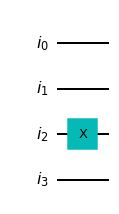

In [3]:
qr_input = QuantumRegister(4, "i")
qc_input = QuantumCircuit(qr_input)

x = "0010"
for i in range(len(x)):
    if x[i] == "1":
        qc_input.x(i)
        
qc_input.draw("mpl")

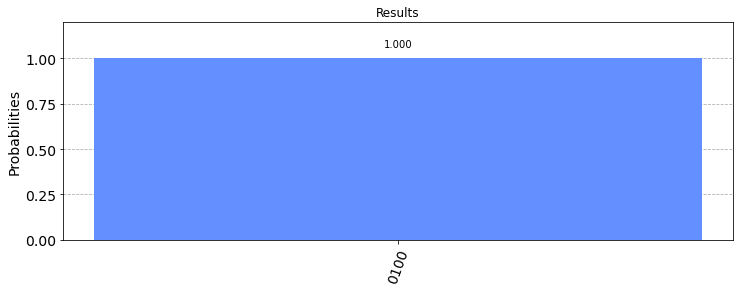

In [4]:
test_circuit(qc_input)

___________


__Training set__

$ \left | T \right > = \frac{1}{\sqrt{N}} \sum_{p=1}^N \left |\vec{v}^p, c^p \right > = \frac{1}{2} \Big ( \left | 0000, 0 \right > + \left | 0001, 0 \right > + \left | 1110, 1 \right > + \left |1111, 1 \right > \Big ) $

In [5]:
X = np.array([[0, 0, 0, 0],
              [0, 0, 0, 1],
              [1, 1, 1, 0],
              [1, 1, 1, 1]])

# number of examples
N = X.shape[0]

# number of features
n = X.shape[1]

y = np.array([0, 0, 1, 1])

# full dataset, of the form [[X], [y]]
dataset = np.append(X, y.reshape((-1, 1)), axis=1)

In [6]:
# n+1 because the last register will encode the class!

amplitudes = np.zeros(2**(n+1))

amplitudes

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
# integer representation of binary strings in training dataset
# notice the [::-1], which is necessary to adjust the endianness!

data_points_X = [int("".join(str(i) for i in X[j])[::-1], 2) for j in range(dataset.shape[0])]

data_points_X

[0, 8, 7, 15]

In [8]:
# integer representation considering also the class
# IMPORTANT: sum 2**n for elements in class 1
# this is necessary to encode also the class!

data_points = [x + 2**n if y[i] == 1 else x for i, x in enumerate(data_points_X)]

data_points

[0, 8, 23, 31]

In [9]:
amplitudes[data_points] = 1

In [10]:
amplitudes = amplitudes/np.sqrt(amplitudes.sum())

amplitudes

array([0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0.5])

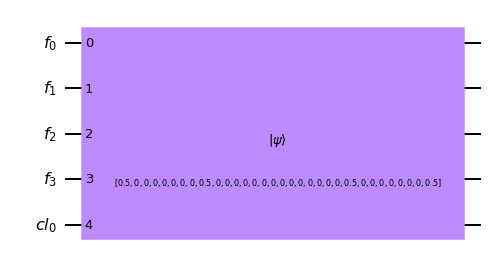

In [11]:
qr_features = QuantumRegister(n, "f")
qr_class = QuantumRegister(1, "cl")

qc_training = QuantumCircuit(qr_features, qr_class)

qc_training.initialize(amplitudes, [qr_features, qr_class])

qc_training.draw("mpl")

Checking if state construction is correct

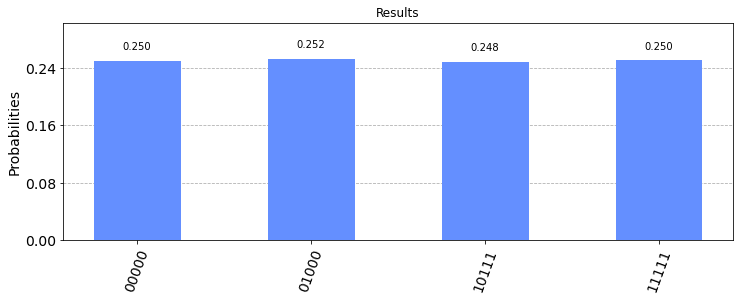

In [12]:
test_circuit(qc_training)

$ \left | T \right > = \frac{1}{\sqrt{N}} \sum_{p=1}^N \left |\vec{v}^p, c^p \right > = \frac{1}{2} \Big ( \left | 0000, 0 \right > + \left | 0001, 0 \right > + \left | 1110, 1 \right > + \left |1111, 1 \right > \Big ) $

In [13]:
dataset

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1]])

___________

__Ancilla__

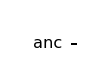

In [14]:
qr_anc = QuantumRegister(1, "anc")
qc_anc = QuantumCircuit(qr_anc)

qc_anc.draw("mpl")


__Full circuit for initial state $\left | \psi_0 \right >$__

$ \left | \psi_0 \right > = \frac{1}{\sqrt{N}} \sum_{p=1}^N \left |\vec{x}, \vec{v}^p, c^p \right > \otimes \left | 0 \right > = \frac{1}{2} \Big ( \left | 0010, 0000, 0 \right > + \left | 0010, 0001, 0 \right > + \left | 0010, 1110, 1 \right > + \left |0010, 1111, 1 \right > \Big ) \otimes \left | 0 \right > $

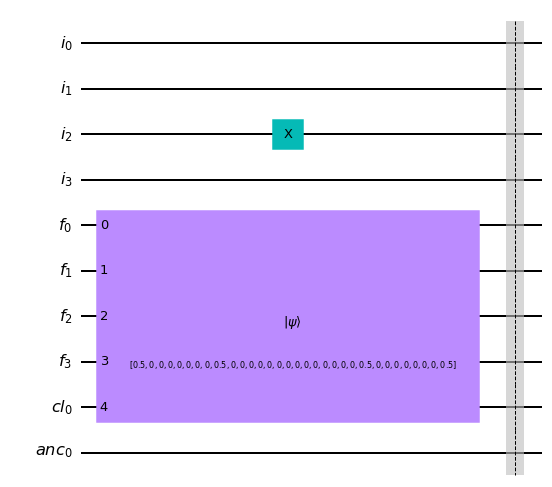

In [15]:
qc = qc_input + qc_training + qc_anc

qc.barrier()

qc.draw("mpl")

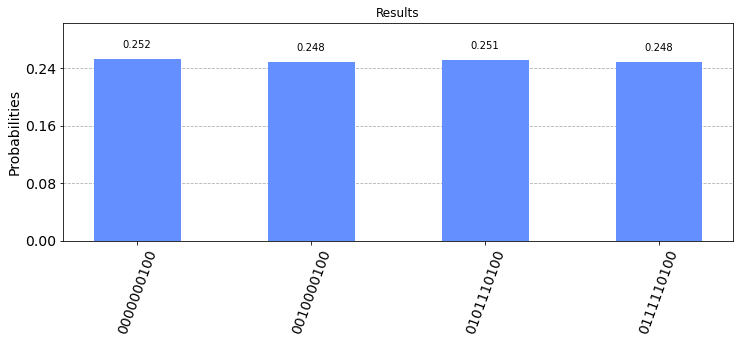

In [16]:
test_circuit(qc)

$ \left | \psi_0 \right > = \frac{1}{\sqrt{N}} \sum_{p=1}^N \left |\vec{x}, \vec{v}^p, c^p \right > \otimes \left | 0 \right > = \frac{1}{2} \Big ( \left | 0010, 0000, 0 \right > + \left | 0010, 0001, 0 \right > + \left | 0010, 1110, 1 \right > + \left |0010, 1111, 1 \right > \Big ) \otimes \left | 0 \right > $

_____________

## Quantum algorithm

__Step 1: ancilla in superposition__

$ \left | \psi_1 \right > = H_{\text{anc}} \left | \psi_0 \right > = \frac{1}{2 \sqrt{2}} \Big ( \left | 0010, 0000, 0 \right > + \left | 0010, 0001, 0 \right > + \left | 0010, 1110, 1 \right > + \left |0010, 1111, 1 \right > \Big ) \otimes \big(\left | 0 \right > + \left | 1 \right > \big) $

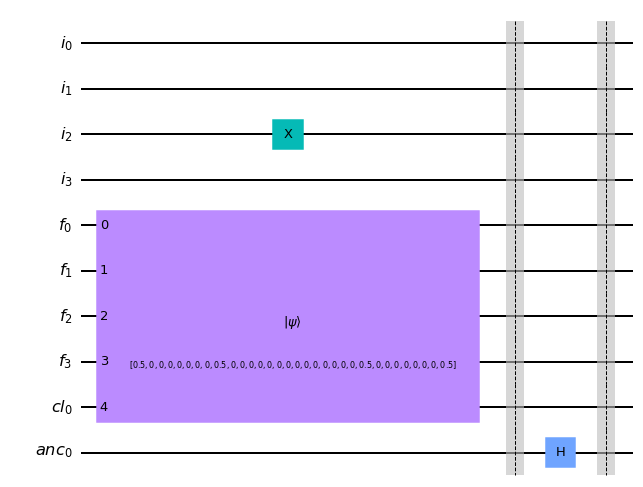

In [17]:
qc.h(-1)

qc.barrier()

qc.draw("mpl")

__Step 2: hamming distance into the second register__

$ \left | \psi_2 \right > = \prod_{k=1}^{n=4} \mathrm{cNOT}(x_k, v^p_k) \left | \psi_1 \right > =
\frac{1}{2 \sqrt{2}} \Big ( 
\left | 0010, 0010, 0 \right > + 
\left | 0010, 0011, 0 \right > + 
\left | 0010, 1100, 1 \right > + 
\left |0010, 1101, 1 \right > \Big )
\otimes 
\big(\left | 0 \right > + \left | 1 \right > \big) $

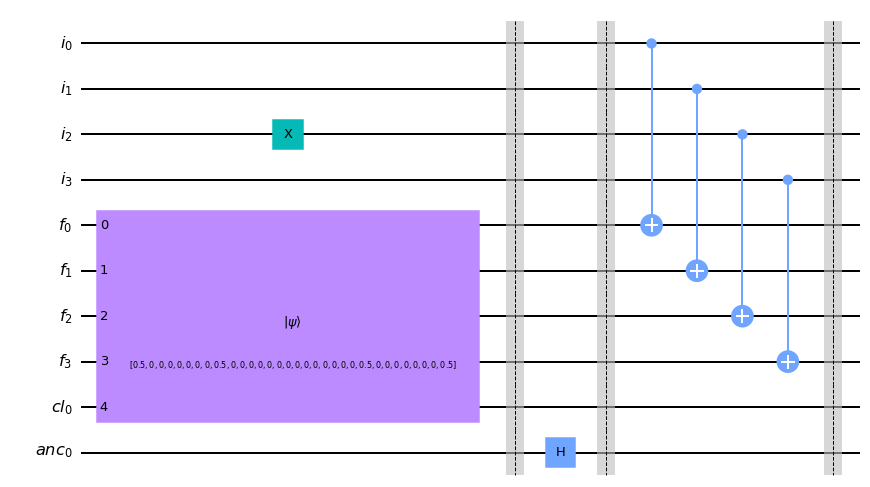

In [18]:
for i in range(4):
    
    qc.cnot(i, 4+i)
    
qc.barrier()
    
qc.draw("mpl")

__Step 3: hamming distance extracted to phase__

$ U = e^{ -i\frac{\pi }{2n} H}  \ ; \qquad\; H = 1 \otimes \sum_{k=1}^n \left(\frac{1-\sigma_z}{2}\right)_{d_k}  \otimes 1 \otimes \sigma_z \ ; $


$ \left | \psi_3 \right > = U \left | \psi_2 \right > = $

$ \frac{1}{2 \sqrt{2}} \Big ( 
e^{-i\frac{\pi}{8}} \left | 0010, 0010, 0 \ ; 0 \right > + 
e^{i\frac{\pi}{8}} \left | 0010, 0010, 0  \ ; 1 \right > + 
e^{-i\frac{\pi}{8}2} \left | 0010, 0011, 0 \ ; 0 \right > + 
e^{i\frac{\pi}{8}2} \left | 0010, 0011, 0 \ ; 1 \right > \Big) $

$ + \frac{1}{2 \sqrt{2}} \Big ( 
e^{-i\frac{\pi}{8} 2} \left | 0010, 1100, 1 \ ; 0 \right > + 
e^{i\frac{\pi}{8} 2} \left | 0010, 1100, 1 \ ; 1 \right > + 
e^{-i\frac{\pi}{8} 3} \left |0010, 1101, 1 \ ; 0 \right >
e^{i\frac{\pi}{8} 3} \left |0010, 1101, 1 \ ; 1 \right > \Big) \ .$



Notice that $H$ is defined in terms of operators acting in each one of the 4 "registers" (input, train/hamming distance, class, ancilla).

Let's write the (single-qubit) unitaries which will be applied to each qubit of the respective register.

__UPDATE__: actually, we can extract the Hamming distance to the exponential phase by applying:

- $e^{  U_1^-} \ ; U_1^- = -i\frac{\pi }{2n} \sum_{k=1}^n \left(\frac{1-\sigma_z}{2}\right)_{d_k}$ to the second register if the ancilla is $\left | 0 \right >$ ; 

- $e^{ U_1^+} \ ; U_1^+ = i\frac{\pi }{2n} \sum_{k=1}^n \left(\frac{1-\sigma_z}{2}\right)_{d_k}$ to the second register if the ancilla is $\left | 1 \right >$ ; 

We do this with controlled unitaries (control: ancillar; target: respective registers)! Let's build them below.

In [19]:
# matrices of 1 and \sigma_z to be exponentiated below
# source of the matrix exponential methods below:
# https://quantumcomputing.stackexchange.com/questions/10317/quantum-circuit-to-implement-matrix-exponential

idtt = np.eye(2)

sz = np.array([[1,0], 
               [0,-1]])

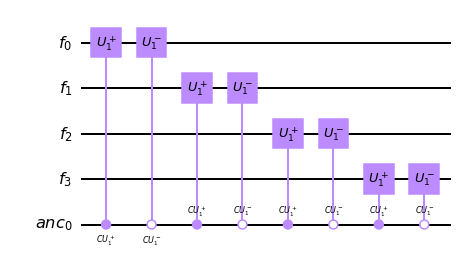

In [20]:
# define the exponentiated unitaries
U_1_minus = expm(-1j * (np.pi/(2*4)) * ((idtt-sz)/2))
U_1_plus = expm(1j * (np.pi/(2*4)) * ((idtt-sz)/2))

# defining controlled gates
u1m = add_control(operation=UnitaryGate(U_1_minus, label="$U_1^-$"),
                  num_ctrl_qubits=1, ctrl_state=0, label="$CU_1^-$")

u1p = add_control(operation=UnitaryGate(U_1_plus, label="$U_1^+$"),
                  num_ctrl_qubits=1, ctrl_state=1, label="$CU_1^+$")


# build a circuit to apply the unitary above
# this will be combined with the main circuit later on (notice: same registers!!).
qc_u = QuantumCircuit(qr_features, qr_anc)
           
for i in range(4):
    
    # apply the unitaries
    qc_u.append(u1p, [qr_anc[0], qr_features[i]])
    qc_u.append(u1m, [qr_anc[0], qr_features[i]])
      
# # decompose this portion of the circuit
# # (this will be appended to the main circuit later on)
# qc_u = qc_u.decompose()

qc_u.draw("mpl")

___________

__Testing the U operator constructed above__

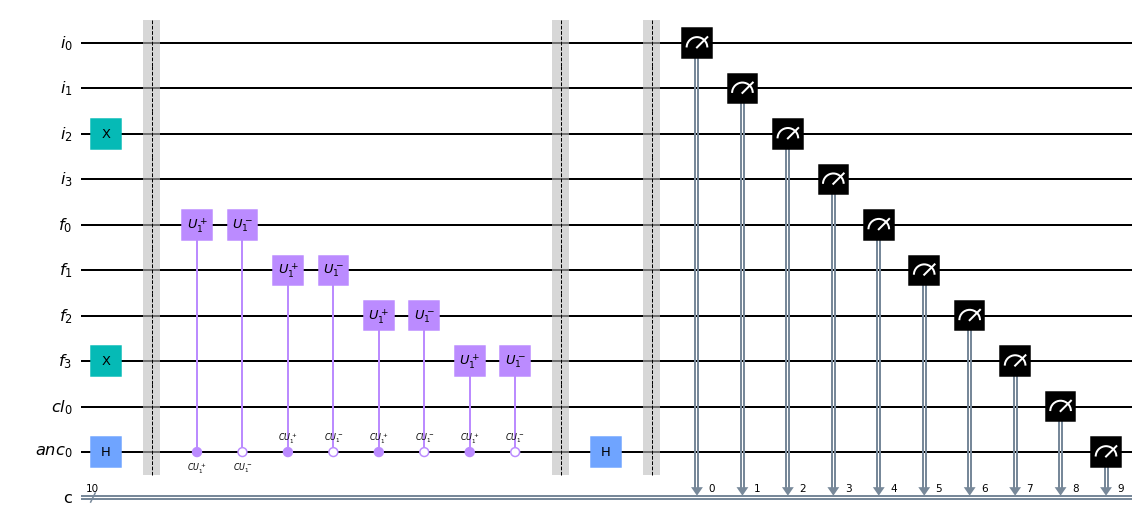

In [21]:
qr_input = QuantumRegister(4, "i")
qr_features = QuantumRegister(4, "f")
qr_class = QuantumRegister(1, "cl")
qr_anc = QuantumRegister(1, "anc")

qc_prep = QuantumCircuit(qr_input, qr_features, qr_class, qr_anc)

# build the state |0010,0110,0 ;1⟩ + |0010,0110,0 ;0⟩

# input
qc_prep.x(qr_input[2])

# hamming ditance
# qc_prep.x(qr_features[1])
# qc_prep.x(qr_features[2])
qc_prep.x(qr_features[3])

# ancilla
qc_prep.h(qr_anc[0])

qc_prep.barrier()

##################################################

qc_test = qc_prep.combine(qc_u)

qc_test.barrier()

##################################################

qc_test.h(qr_anc[0])

qc_test.barrier()

##################################################

cr = ClassicalRegister(qc_test.num_qubits, "c")
qc_cr = QuantumCircuit(cr)

qc_test = qc_test + qc_cr

for i in range(qc_test.num_qubits):
    
    qc_test.measure(i, i)
    
##################################################

qc_test.draw("mpl")

__Testing the state preparation circuit__

This should iyeld a 50/50 superposition

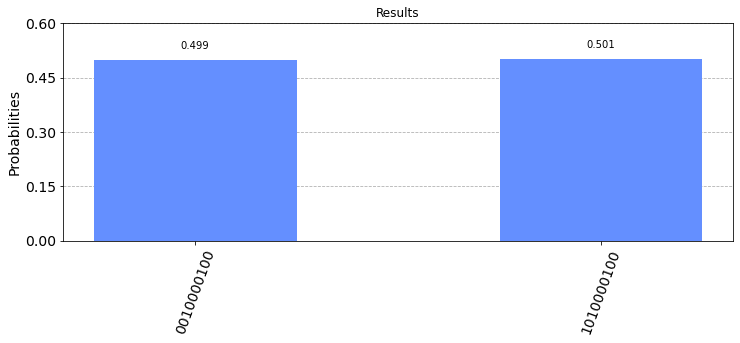

In [22]:
cr = ClassicalRegister(qc_test.num_qubits, "c")
qc_cr = QuantumCircuit(cr)

qc_prep = qc_prep + qc_cr

for i in range(qc_prep.num_qubits):
    
    qc_prep.measure(i, i)

backend = Aer.get_backend("qasm_simulator")

job = execute(qc_prep, backend, shots=1e5, seed_simulator=42)
results = job.result()
counts = results.get_counts()

plot_histogram(counts, title="Results", figsize=(12, 4))

__Testing the circuit with the U operator__

This should yield $\cos^2(\pi d/8)$ in ancilla $ \left | 0\right >$ and $\sin^2(\pi d/8)$ in ancilla $ \left | 1 \right >$

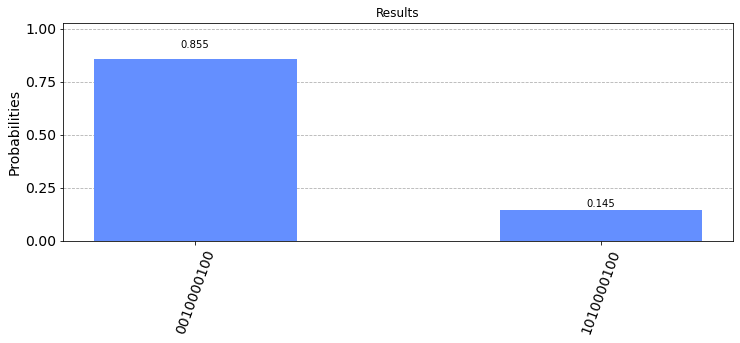

In [23]:
backend = Aer.get_backend("qasm_simulator")

job = execute(qc_test, backend, shots=1e5, seed_simulator=42)
results = job.result()
counts = results.get_counts()

plot_histogram(counts, title="Results", figsize=(12, 4))

In [24]:
print("Ancila 0")

(np.cos(np.pi/8))**2

Ancila 0


0.8535533905932737

In [25]:
print("Ancila 1")

(np.sin(np.pi/8))**2

Ancila 1


0.14644660940672624

____

Now, combine the U circuit above to the main circuit

In [26]:
qc = qc.combine(qc_u)

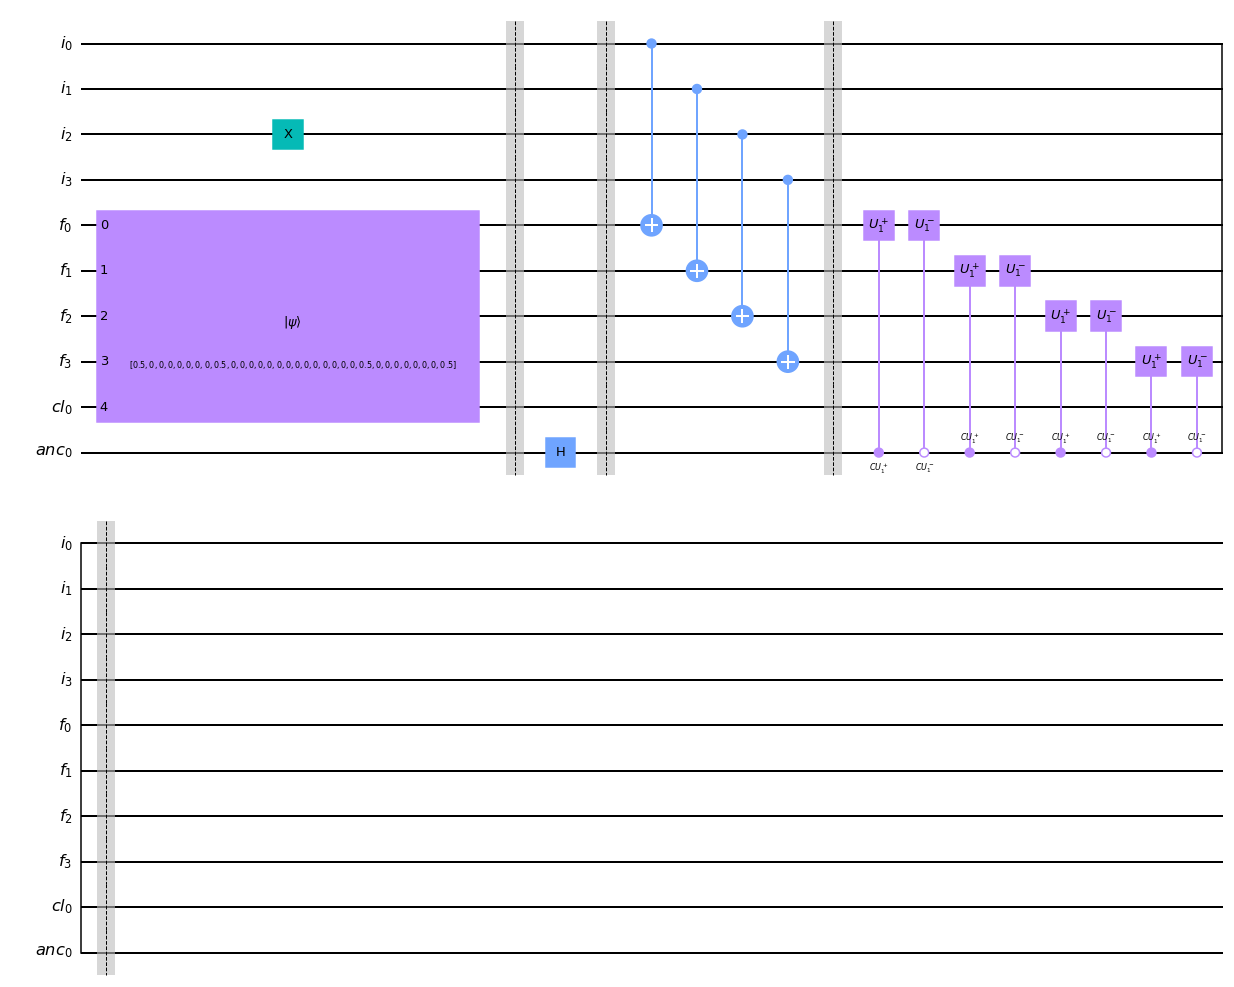

In [27]:
qc.barrier()

qc.draw("mpl")

__Step 4: ancilla in superposition__

$ \left | \psi_4 \right > = H_{\text{anc}} \left | \psi_3 \right > = $

$ \frac{1}{2} \left | 0 \right > \otimes \Big ( 
\cos\left ({\frac{\pi}{8}}  \right) \left | 0010, 0010,  \ ;  0 \right > + 
\sin\left ({\frac{\pi}{8}}  \right) \left | 0010, 0010,  \ ;  1 \right > + 
\cos\left ({\frac{2\pi}{8}} \right) \left | 0010, 0011, \ ;  0 \right > + 
\sin\left ({\frac{2\pi}{8}} \right) \left | 0010, 0011, \ ;  1 \right > \Big) $

$ + \frac{1}{2} \left | 1 \right > \otimes\Big ( 
\cos\left ({\frac{2\pi}{8}} \right) \left | 0010, 1100, \ ;  0 \right > + 
\sin\left ({\frac{2\pi}{8}} \right) \left | 0010, 1100, \ ;  1 \right > + 
\cos\left ({\frac{3\pi}{8}} \right) \left |0010, 1101, \ ;  0 \right >
\sin\left ({\frac{3\pi}{8}} \right) \left |0010, 1101, \ ;  1 \right > \Big) \ .$

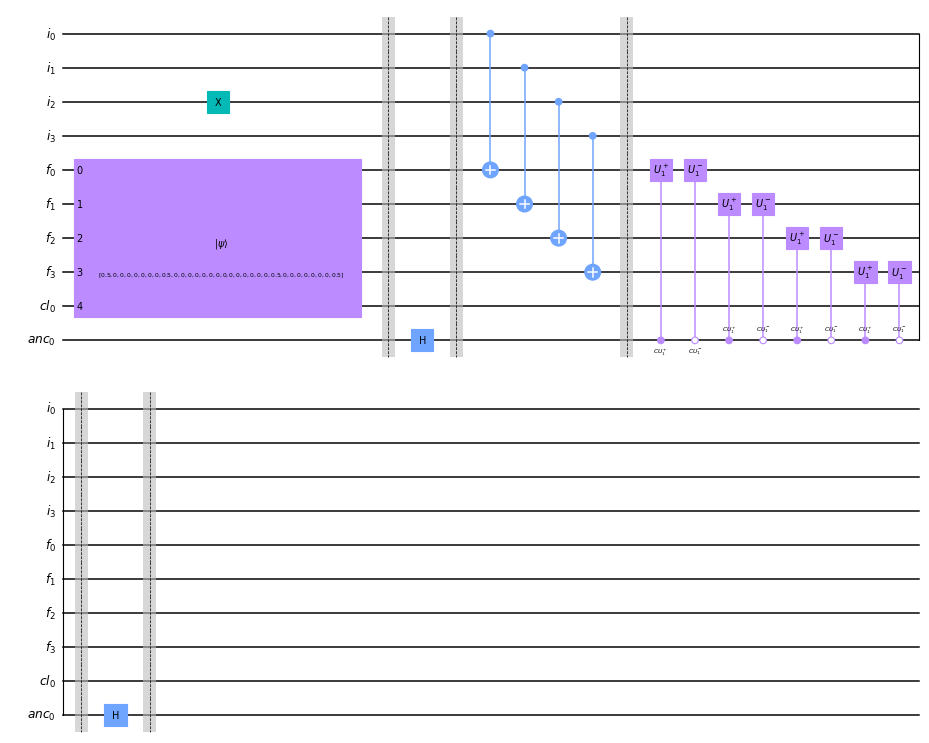

In [28]:
qc.h(-1)

qc.barrier()

qc.draw("mpl", scale=0.75)

In [29]:
# copying the qc so far, before measurement
qc_bckp = qc.copy()

________

__Inspectioning the final state__

In [30]:
qc = qc_bckp.copy()

In [31]:
cr = ClassicalRegister(qc.num_qubits, "c")
qc_cr = QuantumCircuit(cr)

qc = qc + qc_cr

for i in range(qc.num_qubits):
    
    qc.measure(i, i)
    
# qc.draw("mpl")

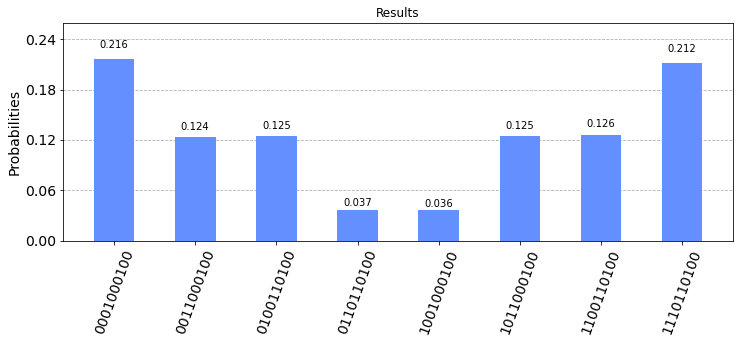

In [32]:
backend = Aer.get_backend("qasm_simulator")

job = execute(qc, backend, shots=1e5, seed_simulator=42)
results = job.result()
counts = results.get_counts()

plot_histogram(counts, title="Results", figsize=(12, 4))

$\left|0010, 0010, 0; 0\right>$ ~ '0001000100': 0.213 vs 0.216 --> OK! <br>
$\left|0010, 0010, 0; 1\right>$ ~'1001000100': 0.037 vs 0.036 --> OK!

$\left|0010, 0011, 0; 0\right>$ ~'0011000100': 0.125 vs 0.124 --> OK! <br>
$\left|0010, 0011, 0; 1\right>$ ~'1011000100': 0.125 vs 0.125 --> Ok! 

$\left|0010, 1100, 1; 0\right>$ ~'0100110100': 0.125 vs 0.125 --> OK!<br>
$\left|0010, 1100, 1; 1\right>$ ~'1100110100': 0.125 vs 0.126 --> OK!

$\left|0010, 1101, 1; 0\right>$ ~'0110110100': 0.037  vs 0.037 --> OK! <br>
$\left|0010, 1101, 1; 1\right>$ ~'1110110100': 0.213 vs 0.212 --> OK!

In [33]:
# using the same endiannes of qiskit, i.e., |0010,0010,0;0> = 0001000100

{"0001000100" : round((0.25)*(np.cos(np.pi/8))**2, 3),
 "1001000100" : round((0.25)*(np.sin(np.pi/8))**2, 3),
 
 "0011000100" : round((0.25)*(np.cos(2*np.pi/8))**2, 3),
 "1011000100" : round((0.25)*(np.sin(2*np.pi/8))**2, 3),
 
 "0100110100" : round((0.25)*(np.cos(2*np.pi/8))**2, 3),
 "1100110100" : round((0.25)*(np.sin(2*np.pi/8))**2, 3),
 
 "0110110100" : round((0.25)*(np.cos(3*np.pi/8))**2, 3),
 "1110110100" : round((0.25)*(np.sin(3*np.pi/8))**2, 3)}

{'0001000100': 0.213,
 '1001000100': 0.037,
 '0011000100': 0.125,
 '1011000100': 0.125,
 '0100110100': 0.125,
 '1100110100': 0.125,
 '0110110100': 0.037,
 '1110110100': 0.213}

__Above are the espective theoretical probabilities__

Given that 
    
$ \left | \psi_4 \right > = \frac{1}{2} \Big ( 
\cos\left ({\frac{\pi}{8}}  \right) \left | 0010, 0010, 0  \ ;  0 \right > + 
\sin\left ({\frac{\pi}{8}}  \right) \left | 0010, 0010, 0  \ ;  1 \right > + 
\cos\left ({\frac{2\pi}{8}} \right) \left | 0010, 0011, 0 \ ;  0 \right > + 
\sin\left ({\frac{2\pi}{8}} \right) \left | 0010, 0011, 0 \ ;  1 \right > \Big) $

$ + \frac{1}{2} \Big ( 
\cos\left ({\frac{2\pi}{8}} \right) \left | 0010, 1100, 1 \ ;  0 \right > + 
\sin\left ({\frac{2\pi}{8}} \right) \left | 0010, 1100, 1 \ ;  1 \right > + 
\cos\left ({\frac{3\pi}{8}} \right) \left |0010, 1101, 1 \ ;  0 \right >
\sin\left ({\frac{3\pi}{8}} \right) \left |0010, 1101, 1 \ ;  1 \right > \Big) \ .$ 


________

## Step 5 - measurement

Now, it's convenient to write $\left | \psi_4 \right >$ as

$ \left | \psi_4 \right > = \frac{1}{2} \left | 0 \right > \otimes \Big ( 
\cos\left ({\frac{\pi}{8}}  \right) \left | 0010, 0010  \ ;  0 \right > + 
\sin\left ({\frac{\pi}{8}}  \right) \left | 0010, 0010  \ ;  1 \right > + 
\cos\left ({\frac{2\pi}{8}} \right) \left | 0010, 0011 \ ;  0 \right > + 
\sin\left ({\frac{2\pi}{8}} \right) \left | 0010, 0011 \ ;  1 \right > \Big) $

$ + \frac{1}{2} \left | 1 \right > \otimes \Big ( 
\cos\left ({\frac{2\pi}{8}} \right) \left | 0010, 1100 \ ;  0 \right > + 
\sin\left ({\frac{2\pi}{8}} \right) \left | 0010, 1100 \ ;  1 \right > + 
\cos\left ({\frac{3\pi}{8}} \right) \left |0010, 1101 \ ;  0 \right >
\sin\left ({\frac{3\pi}{8}} \right) \left |0010, 1101 \ ;  1 \right > \Big) \ .$

First, we measure the ancilla qubit; then, the class qubit.



__Classical register for measurement - ancilla__

In [34]:
qc = qc_bckp.copy()

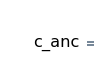

In [35]:
# first, lets's measure the ancilla

cr_anc = ClassicalRegister(1, "c_anc")
qc_cr_anc = QuantumCircuit(cr_anc)

qc_cr_anc.draw("mpl")

In [36]:
qc = qc + qc_cr_anc

qc.measure(qr_anc, cr_anc[0])

# qc.draw("mpl", scale=0.7)

The probability of measuring the ancilla qubit to be in $\left | 0 \right >$ is

$ P(\left | 0 \right >_a) = \left |   \left < 0 | \psi_4 \right >  \right |^2 =  \frac{1}{N} \sum_{p=1}^{N=4}  \cos^2\left (\frac{\pi d_H}{2n} \right) = \frac{1}{4} \Big ( \cos^2\left ({\frac{\pi}{8}} \right ) + \cos^2\left ({\frac{2\pi}{8}} \right ) + \cos^2\left ({\frac{2\pi}{8}} \right ) + \cos^2\left ({\frac{3\pi}{8}} \right ) \Big) = \frac{1}{2}$

In [37]:
# theoretical probability of measuring ancilla in |0>

(0.25)*((np.cos(np.pi/8))**2 + 2*(np.cos(2*np.pi/8))**2 + (np.cos(3*np.pi/8))**2)

0.5000000000000001

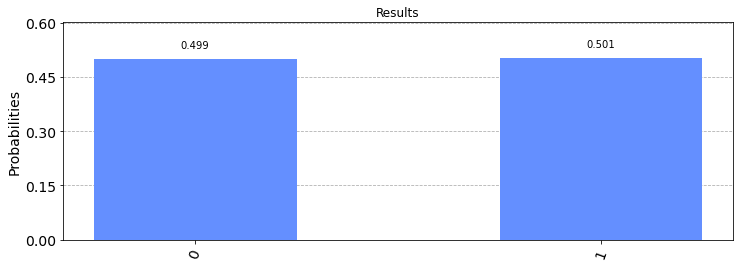

In [38]:
backend = Aer.get_backend("qasm_simulator")

job = execute(qc, backend, shots=1e4, seed_simulator=42)
results = job.result()
counts = results.get_counts()

plot_histogram(counts, title="Results", figsize=(12, 4))

________

__Classical register for measurement - class + ancilla__

Let's implement both the measurements:

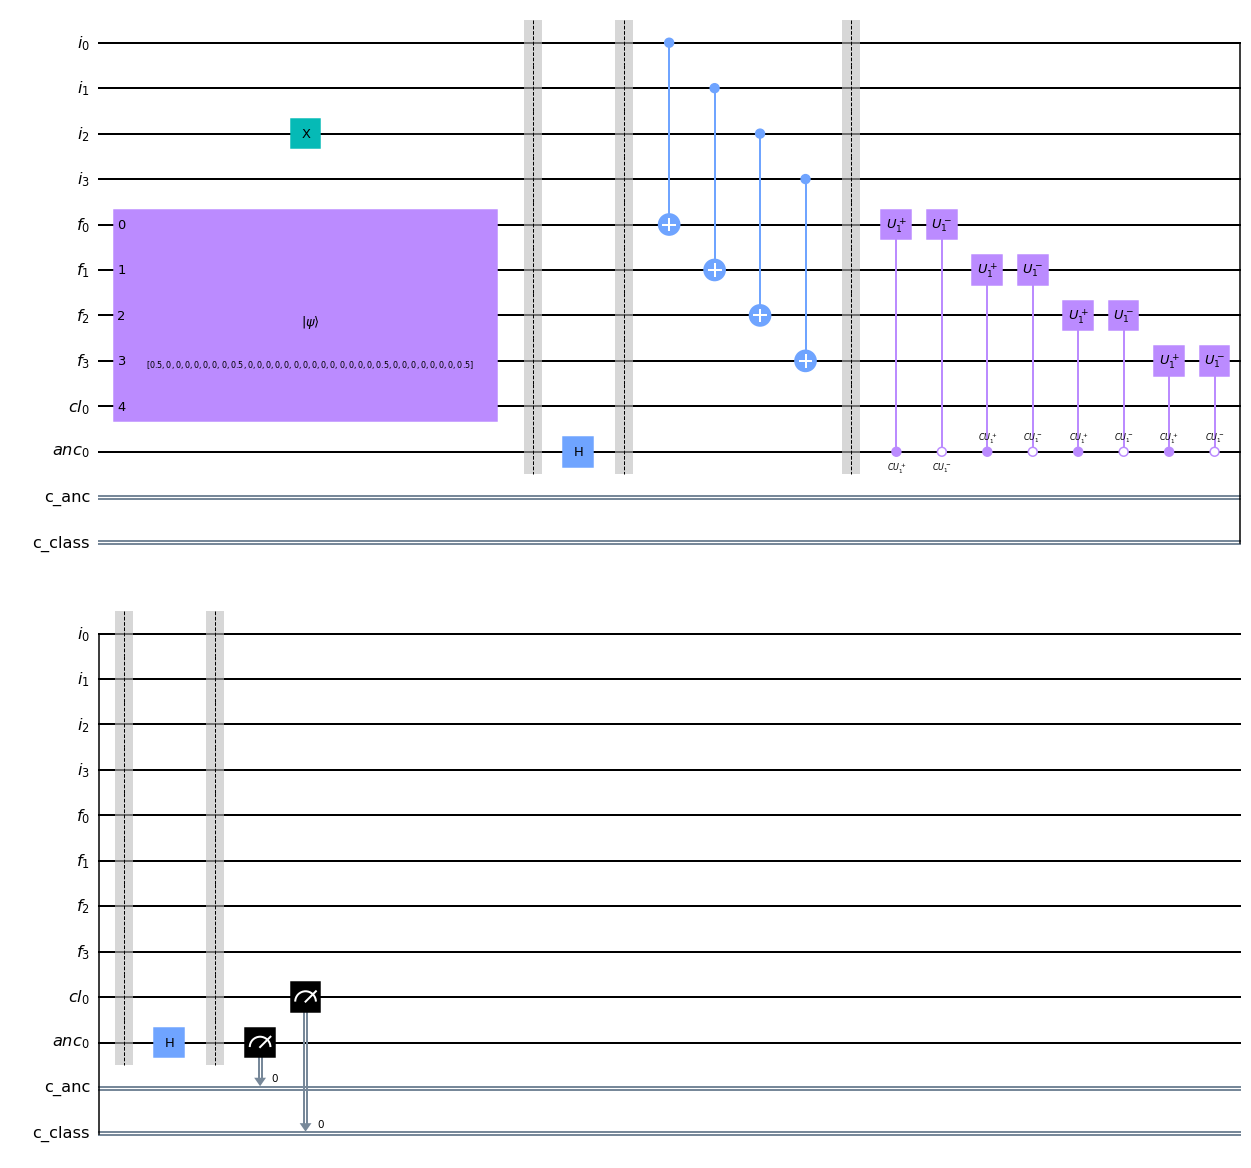

In [39]:
qc = qc_bckp.copy()

cr_anc = ClassicalRegister(1, "c_anc")
qc_cr_anc = QuantumCircuit(cr_anc)

cr_class = ClassicalRegister(1, "c_class")
qc_cr_class = QuantumCircuit(cr_class)

qc = qc + qc_cr_anc + qc_cr_class

qc.measure(qr_anc, cr_anc)
qc.measure(qr_class, cr_class)

qc.draw("mpl")

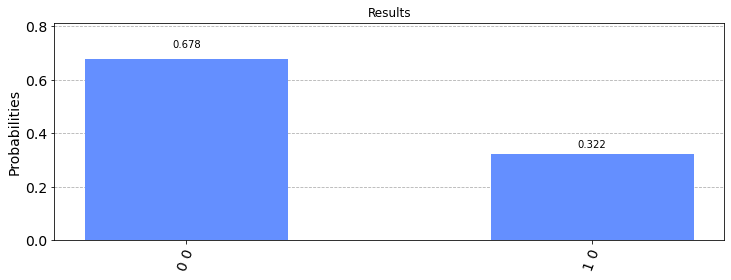

In [40]:
backend = Aer.get_backend("qasm_simulator")

job = execute(qc, backend, shots=1e4, seed_simulator=42)
results = job.result()
counts = results.get_counts()

# filtering out measurements of ancila = |1> (last register)
keys = list(counts.keys()).copy()
for key in keys:
    
    if key[-1] == "1":
        
        counts.pop(key)

plot_histogram(counts, title="Results", figsize=(12, 4))

The probability of measuring the qubit in a given class $c$, given that the ancilla was beasured to be in $\left | 0 \right >$, is

$P(c) =  \frac{1}{ P(\left | 0 \right >_a)}\frac{1}{N} \sum \limits_{l\in c} \cos^2\left (\frac{\pi d_H}{2n} \right) = \frac{1}{2} \sum \limits_{l\in c} \cos^2\left (\frac{\pi d_H}{2n} \right) \ , $

Thus, 

$ P(c=0) = \frac{1}{2} \Big ( \cos^2\left ({\frac{\pi}{8}} \right ) + \cos^2\left ({\frac{2\pi}{8}} \right ) \Big) \approx 0.68$

$ P(c=1) = \frac{1}{2} \Big ( \cos^2\left ({\frac{2\pi}{8}} \right ) + \cos^2\left ({\frac{3\pi}{8}} \right ) \Big) \approx 0.32$

In [41]:
# theoretical probability of measuring class qubit in |0>, given ancilla was in |0>

(0.5)*((np.cos(np.pi/8))**2 + (np.cos(2*np.pi/8))**2)

0.676776695296637

In [42]:
# probability of measuring class qubit in |1>, given ancilla was in |0>

(0.5)*((np.cos(2*np.pi/8))**2 + (np.cos(3*np.pi/8))**2)

0.3232233047033632

Simulation results match theoretical expectations!

_____________